## James O'Rourke 15334121

**Assignment 2** focuses on the training on a Neural Machine Translation (NMT) system with an attention model.

This is an **individual assignment** and usual rules for plagiarism apply! With this you agree that: "In submitting this work I confirm that it is entirely my own. I acknowledge that I may be invited to online interview if there is any concern in relation to the integrity of my exam." 

**Write comments and documentation.**





In [ ]:
#Loading some libraries i need

import re
import numpy as np
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense,Embedding, Attention
import nltk
from google.colab import files


## Section 1- Data Collection and Preprocessing 


---


**Task 1  (5 marks)**

---

There are few datasets to train an NMT system available from the OPUS project (http://opus.nlpl.eu/).

*  Download a language pair (preferably European language) and **extract** the file(s) and upload it to CoLab
*  Create a list of lines by splitting the text file at every occurrence accordingly, i.e. source and target language
*  Print number of sentences
*  Limit the number of sentences to 10,000 lines (but more than 5,000 lines)
*  Split the data into train, development and test set
*  Print 100th sentence in original script for source and target language

In [ ]:
#Slect the two corpus here Tatoeba.en.txt and Tatoeba.fr.txt
uploaded = files.upload()

Saving Tatoeba.en.txt to Tatoeba.en.txt
Saving Tatoeba.fr.txt to Tatoeba.fr.txt


In [ ]:
#The paths to the corpus files, English and French
#I chose Tatoeba because they were nice and small phrases which suits the memory limations in Collab.
#Tried using irish but the offered corpuses were insufficent 

engPath =  "Tatoeba.en.txt"

frPath = "Tatoeba.fr.txt"


#Reading the 2 files to as a list
with open(engPath , 'r') as eng_file:
  englines=eng_file.read().split('\n')

with open(frPath , 'r') as fr_file:
  frlines=fr_file.read().split('\n')

#Will loop through all the lines and only keep lines with length 20 or less and add to lists below
engText = []
frText = []

#Checked word count in English 
for i in range(len(englines)):
  enline = englines[i]
  frline = frlines[i]
  if len(enline) < 21:
    engText.append(enline)
    frText.append(frline)

print("100th line in source langauge is: ",engText[100])
print("100th line in target langauge is: ",frText[100])

#Will keep 1000 sentences for this assignment but will make the split later

#Will reserve 90% of the data for training and 10% for testing
splitNumber = int(0.90*len(engText))

print("Number of sentences in courpus: ",len(engText))


#My training data
trainEn = engText[:splitNumber]
trainfr = frText[:splitNumber]

#My testing data
testEn = engText[splitNumber:]
testfr = frText[splitNumber:]


100th line in source langauge is:  Nobody came. 
100th line in target langauge is:  Personne n'est venu. 
Number of sentences in courpus:  39795


**Task 2 (5 marks)** 

---

* Add '<bof\>' to denote beginning of sentence and '<eos\>' to denote the end of the sentence to each target line.
* Perform the pre-processing step of the text.
* Print the last 5 sentences of the preprocessed text.
* Print statistics on the selected dataset:
  * Number of samples
  * Number of unique source language tokens
  * Number of unique target language tokens
  * Max sequence length of source language
  * Max sequence length of target language
  * Source Vocabulary
  * Target Vocabulary





For cleaning of text I removed the all punctuation and I also removed numbers if in the numerial form i.e. 1000 but not one thousand. I also converted the text to lowercase trimmed extra white space.

I chose not to do any stemming or lemmization as I was unsure how the functions would effect the french words. My data did not contain many named entites beyond a few names and didnt remove them.

In [ ]:

#remove punctutation, numbers, and extra space
def cleanText(lineString):
  #remove digits
  clean = re.sub(r"\d+", "", lineString)
  #leave only words and spaces
  clean = re.sub(r'[^\w\s]','',clean)
  #remove extra space
  clean = re.sub(' +', ' ',clean)
  #trim the surrounding white space
  clean = clean.strip()
  #return the string in lower case
  return clean.lower()

#setting my lists for the texts temporaly
temp_input_texts = list()
temp_target_texts = list()

#sets for storing my vocab
input_words = set()
target_words = set()


#Goes through the text and performs the text cleaning
for k in range(len(trainfr)):

  cleanfr = cleanText(trainfr[k])
  cleanEn =  cleanText(trainEn[k])
  #Adds the markers for the start and end of target sentence 
  cleanfr = '<bof> '+ cleanfr +' <eos>'
  #add them to our temporary text lists
  temp_input_texts.append(cleanEn)
  temp_target_texts.append(cleanfr)



input_texts = []
target_texts = []


#Making sure my target_texts are't too long
#I check the length in charcters here but after here I mostly use length of the sentecnes in words
for i in range(min(10000,len(temp_input_texts))):
  enline = temp_input_texts[i]
  frline = temp_target_texts[i]
  if len(frline) < 40:
    input_texts.append(enline)
    target_texts.append(frline)

    #adding input text to vocab
    for worden in enline.split():
      if worden not in input_words:
            input_words.add(worden)

    #adding target words to vocab
    for word in  frline.split():
      if word not in target_words:
        target_words.add(word)


#I considered adding a unknown token to the input vocab and while this lead a higher BLEU it did lead to less coherent sentences I felt 
#input_words.add("<unk>")


In [ ]:

#Gettting the stats and printing them off
input_words_vocab = sorted(list(input_words))
target_words_vocab = sorted(list(target_words))
num_encoder_tokens = len(input_words_vocab)
num_decoder_tokens = len(target_words_vocab)
max_encoder_seq_length = max([len(txt.split()) for txt in input_texts])
max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])


print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs in words:", max_encoder_seq_length)
print("Max sequence length for outputs in words:", max_decoder_seq_length,"\n")

print("Input word vocab",input_words_vocab)
print("Target word vocab",target_words_vocab,"\n")

for i in range(len(input_texts)-5,len(input_texts)):
  print("##########################################")
  print("Preprocessed Sentence number ",i,"\n")
  print("Source Sentence: ",input_texts[i],"\n")
  print("Target Sentence: ",target_texts[i],"\n")



Number of samples: 9345
Number of unique input tokens: 2587
Number of unique output tokens: 4176
Max sequence length for inputs in words: 6
Max sequence length for outputs in words: 10 

Input word vocab ['a', 'abandon', 'abating', 'abbott', 'abhor', 'able', 'aboard', 'about', 'above', 'abreast', 'abroad', 'absent', 'absentees', 'absurd', 'accelerated', 'accept', 'according', 'account', 'ache', 'ached', 'aches', 'aching', 'achoo', 'acid', 'acquitted', 'act', 'action', 'actions', 'active', 'actor', 'actors', 'actresses', 'acts', 'add', 'addict', 'address', 'adjust', 'admire', 'admission', 'admit', 'adopted', 'adores', 'adults', 'advance', 'adventure', 'advice', 'advised', 'affair', 'afraid', 'after', 'afternoon', 'again', 'against', 'age', 'ages', 'aggressive', 'ago', 'agree', 'agreed', 'agreement', 'ah', 'ahead', 'ahhh', 'ahmad', 'aint', 'air', 'airmail', 'airplane', 'aisle', 'alains', 'alarm', 'album', 'alex', 'alice', 'alike', 'alive', 'all', 'allah', 'allen', 'allow', 'allowed', 'al

I nocticed that removing commas has caused contactions in the french eg j'ai -> jai . I will have to keep this in mind when it comes to making predictions. This is an exmaple why I was apprensive about stemming and lemmization and why in the end I didnt do it.

**Task 3 (5 marks)** 

---

---

*  Assign each unique word an integer value (5 marks).
*  Create word embedding for your vocabulary using pre-trained embeddings, for example GloVe or fastText (10 marks) (https://nlp.stanford.edu/projects/glove/ , https://fasttext.cc/docs/en/english-vectors.html)
* Print the first line of the embeddings (see below) 

In [ ]:
input_token_index = dict([(word,i) for i, word in enumerate(input_words)])
target_token_index= dict([(word,i) for i, word in enumerate(target_words)])

print(len(input_token_index))
print(len(target_token_index))


2587
4176


I was having trouble using the glove pre-trained word embeddings. For example, it didn't like french words with accents such as journée. I realise I could have removed them by converting it all to Unicode but I was worried about different words being embedded the same.

 I made word embeddings using sequences of integers by using the value we assigned to each unique word. I know this makes it very small when compared to glove embeddings and this dimension reduction might affect my model but it should allow me to run more epochs and it will be faster.

decoder_input_data is one hot encoded and is not a sequence of integers like the others.


In [ ]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length),dtype='float32')

decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length),dtype='float32')

decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens),dtype='float32')

# create the data. Adapted the code from the lab for my use
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [ ]:
print(np.shape(encoder_input_data))
print(np.shape(decoder_input_data))
print("---------------------------")
print(encoder_input_data[1])
print(input_texts[1])

print(decoder_input_data[1])
print(target_texts[1])

(9345, 6)
(9345, 10)
---------------------------
[ 569. 2302. 2336. 1199. 2369.    0.]
you are in my way
[2718. 3891. 2863. 1395. 3360. 2435. 3806.    0.    0.    0.]
<bof> tu es sur mon chemin <eos>


As you can see my emdedings are sequences of length of the max number of words in a sentence with the word being represented by its unique integer.


## Section 2 Translation Model training



---



**Task 4 (15 marks)**
* Provide code for the encoder using Keras LSTM (5 marks)
* Provide code for the decoder using Keras LSTM (5 marks)
* Train the sequence2sequence (encoder-decoder) model (5 marks) 


In [ ]:
#Setting the hyperparamters for the model
batch_size= 128 #batch size
epochs = 50 #could keep epochs very high as my emededings are very small. 
dim = 128 #dimension size

My model is very simlar to the one we used to the lab except I used a embedding layer after each input and it is adpated to a word level. I use the lecture notes, the lab material and this keras example as refrences (https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html)

In [ ]:
#encoder code 
#I left the input size of my models as None. Whenever I defined the size I ran into errors later on and couldn't figure it out, even when my inouts were the same

#Input layer
encoder_inputs = Input(shape=(None,))
# input words embedding
enEmbedd =  Embedding(num_encoder_tokens, dim)(encoder_inputs)
# defining the LSTM layer and then passes the Embeddings_input
encoder = LSTM(dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(enEmbedd)
# keep the states from the encoder 
encoder_states = [state_h, state_c]


In [ ]:
#decoder code 
decoder_inputs = Input(shape=(None,))
# target word embeddings
frEmbedd =  Embedding(num_decoder_tokens, dim)
frData = frEmbedd(decoder_inputs)

#defining the decoder embedding layer and then passes the embeddings
#We pass the states from the encoder lstm layer 
decoder_lstm = LSTM(dim, return_sequences=True, return_state=True)
#We only keep the outputs not the states from the LSTM
decoder_outputs, _, _ = decoder_lstm(frData ,
                                     initial_state=encoder_states)
#Our decoder layers, defined and then executed with the decoder outputs
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


In [ ]:
#Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
 
#Compile the model 
#optimiser is  rmsprop
#loss fucntion is categorical crossentropy
#accuracy as metric
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])


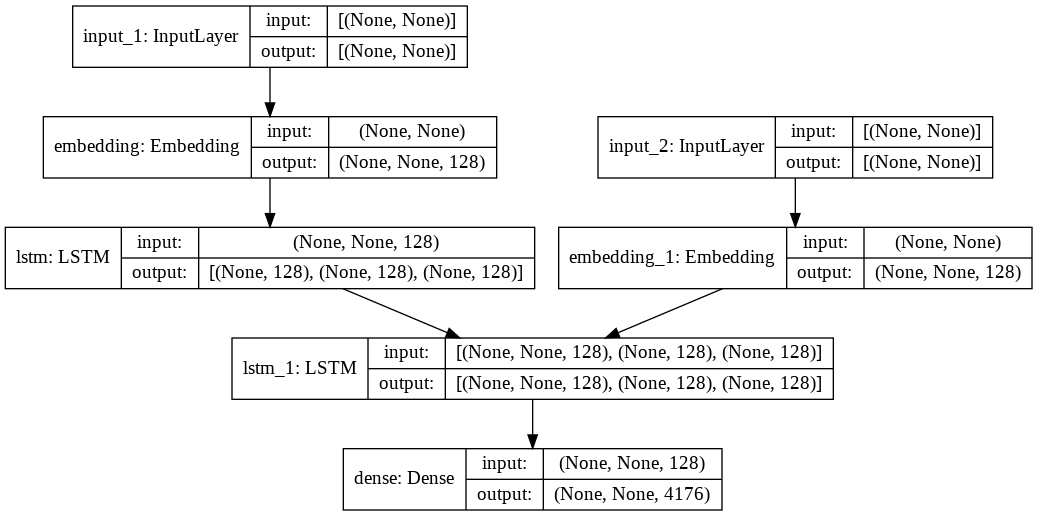

In [ ]:
#Plotting the model so I can see it better
tf.keras.utils.plot_model(
    model, show_shapes=True,
    show_layer_names=True
)

In [ ]:
#This runs the training of the model
#May take a while so beware
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
model.save('seq2seq_source_target.h5')

Epoch 1/50
59/59 [==============================] - 37s 47ms/step - loss: 2.9934 - accuracy: 0.0922 - val_loss: 2.4801 - val_accuracy: 0.1000
Epoch 2/50
59/59 [==============================] - 2s 34ms/step - loss: 2.5081 - accuracy: 0.1049 - val_loss: 2.4951 - val_accuracy: 0.1145
Epoch 3/50
59/59 [==============================] - 2s 34ms/step - loss: 2.4777 - accuracy: 0.1142 - val_loss: 2.5030 - val_accuracy: 0.1147
Epoch 4/50
59/59 [==============================] - 2s 34ms/step - loss: 2.4558 - accuracy: 0.1149 - val_loss: 2.5196 - val_accuracy: 0.1148
Epoch 5/50
59/59 [==============================] - 2s 35ms/step - loss: 2.4289 - accuracy: 0.1155 - val_loss: 2.5384 - val_accuracy: 0.1147
Epoch 6/50
59/59 [==============================] - 2s 34ms/step - loss: 2.4228 - accuracy: 0.1156 - val_loss: 2.5423 - val_accuracy: 0.1147
Epoch 7/50
59/59 [==============================] - 2s 34ms/step - loss: 2.3997 - accuracy: 0.1152 - val_loss: 2.5378 - val_accuracy: 0.1147
Epoch 8/50
5

## Section 3 Testing

---

**Task 5 (20 marks)**

* Use the trained model to translate the text from the source into the target language (10 marks). 
* Use the test/evaluation set (see Section 1) and perform an automatic evaluation with the BLEU metric (10 marks). 
You can use the NLTK library to calculate BLEU.

In [ ]:
model = keras.models.load_model('seq2seq_source_target.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    331136      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    534528      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
#Making model for inferance

# define the encoder model 
encoder_model = Model(encoder_inputs, encoder_states)


# Redefine the decoder model with decoder will be getting below states from encoder while in prediction
decoder_state_input_h = Input(shape=(dim,))
decoder_state_input_c = Input(shape=(dim,))


decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decode_embeds = frEmbedd(decoder_inputs)

decoder_outputs, state_h, state_c = decoder_lstm(decode_embeds, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

#The final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
# reverse-lookup token index to turn sequences back to characters
reverse_input_word_index = dict(
  (i, word) for word, i in input_token_index.items())
reverse_target_word_index = dict(
  (i, word) for word, i in target_token_index.items())

In [ ]:
clean_test_en = []
clean_test_fr = []

#Before I start evaluating I need to clean my and prep my training data i.e. run it through my clean function
for k in range(len(testEn)):

  cleanfr = cleanText(testfr[k])
  cleanEn =  cleanText(testEn[k])
 
  #add them to our temporary text lists
  clean_test_en.append(cleanEn)
  clean_test_fr.append(cleanfr)

print(clean_test_en[1])
print(clean_test_fr[1])

#Keep 1000 test samples
clean_test_en = clean_test_en[:1000]
clean_test_fr = clean_test_fr[:1000]



print("We have ",len(clean_test_fr)," sentences of testing data")

max_encoder_test_sequnce_test =  max([len(txt.split()) for txt in clean_test_en])

i want this guitar
je veux cette guitare
We have  1000  sentences of testing data


In [ ]:
#setting the representation for my testing data
encoder_input_test_data = np.zeros((len(clean_test_en), max_encoder_test_sequnce_test),dtype='float32')

for i in range(0,len(clean_test_en)):
  for t in range(0,len(clean_test_en[i].split())):
    line = clean_test_en[i].split()
    if line[t] in input_token_index:
      encoder_input_test_data[i, t] = input_token_index[line[t]]
   

In [ ]:
def decode_sequence(input_seq):
    # Encode the input  state vectors to get state vectors
    states_value = encoder_model.predict(input_seq)
    
    #start a squence of 1,1 and add the start character
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['<bof>']

    
    #the output builder loop
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        # Sample a token and add the word to decode sequence 
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+ sampled_word

        # Stops when it either hit max word length  or find <bof>
        if (sampled_word == '<eos>' or
           len(decoded_sentence.split()) > max_decoder_seq_length):
            stop_condition = True
        
        # Update the target sequence 
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    #return the decoded_sentence/sentence
    return decoded_sentence

In [ ]:
#Create lists for predictions and ground truth
y_true = []

y_hat = []

#getting some data ready for calcualting BLEU score
for sentence in clean_test_fr:
  y_true.append(sentence.split())


In [ ]:
#Will calculate the overall BLEU score for the corpus using the relevant BLEU function from nltk
#Have a lot of testing samples so does take some time

for sent in range (len(encoder_input_test_data)):
  input_sequence = encoder_input_test_data[sent:sent + 1]
  decoded_sentence = decode_sequence(input_sequence)

  #This appends the sentence to the predictions as a list minus the <eos> token as the BLEU function doesnt like it
  y_hat.append(decoded_sentence.split()[:-1])


In [ ]:
 BLEU = round(nltk.translate.bleu_score.corpus_bleu(y_true,y_hat),3)
 print("After evaluation on unseen data, we can see our BLEU is ",BLEU)

After evaluation on unseen data, we can see our BLEU is  0.255


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
#Will print some random samples to show my results
import random
sampleLines =  random.sample(range(len(y_hat)),5)


for i in sampleLines:
  print("#############################################")
  print("Sample :",i)
  print("Orginal English Sentence : ",clean_test_en[i])
  print("Orginal translation Sentence : ",clean_test_fr[i])
  print("Predicted translation : "," ".join(y_hat[i]))
  print("\n")

#############################################
Sample : 986
Orginal English Sentence :  did that work
Orginal translation Sentence :  estce que ça a marché
Predicted translation :  faites le


#############################################
Sample : 453
Orginal English Sentence :  we love what we do
Orginal translation Sentence :  nous aimons ce que nous faisons
Predicted translation :  nous sommes


#############################################
Sample : 461
Orginal English Sentence :  do you eat a lot
Orginal translation Sentence :  mangestu beaucoup
Predicted translation :  fais vous le


#############################################
Sample : 635
Orginal English Sentence :  i need new tires
Orginal translation Sentence :  il me faut des pneus neufs
Predicted translation :  jai besoin un


#############################################
Sample : 94
Orginal English Sentence :  no one was seen
Orginal translation Sentence :  on na vu personne
Predicted translation :  personne nest pas




#Anlaysis of results

With a BLEU of around 0.3 with 100 epochs of training our model isn't great, but looking over the 5 random sampled sentences, some of the translations make good semantic sense.

Dissonantly the BLEU function tells me it found no 2-gram overlaps in the whole corpus. Perhaps not using the Glove pre-trained embeddings limited the model before I even started. I would redo it but unfortunately, I will not have time to retry it. Both my training accuracy and validation accuracy were increasing at 100 epochs but very slowly so perhaps if I ran the model for a very long time, it would have been better.

I will implement attention into the model and see if that improves my model.


# Section 4 Attention

---



**Task 5 (40 Marks)** Sequence2Sequence

* Extend the existing Seq2Seq model with an attention mechanism [Discussed in Class]
* Create sequence2sequence model with attention (15 marks)
* Train the model with the same data from Section 1 (10 marks)
* Translate the evaluation set using the sequence2sequence attention model (10 marks)
* Evaluate the translations made with the sequence2sequence attention model and compare it with the model without attention using BLEU (5 marks)

The only difference between my first model and this model is that I am adding a attention layer before the final dense layer. I will be using the keras attention layer and used this page to help my implement it. https://keras.io/api/layers/attention_layers/attention/


In [ ]:

#encoder code the exact same as before
#Input layer
encoder_inputs = Input(shape=(None,))
# English words embedding
enData =  Embedding(num_encoder_tokens, dim)(encoder_inputs)
# defining the LSTM layer and then passes the Embeddings
encoder_lstm = LSTM(dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enData)
# keep the states from the encoder 
encoder_states = [state_h, state_c]

In [ ]:
#Decoder  code with attention


decoder_inputs = Input(shape=(None,))
# french word embeddings
frData =  Embedding(num_decoder_tokens, dim)(decoder_inputs)


#We pass the states from the encoder lstm layer 
decoder_lstm = LSTM(dim, return_sequences=True, return_state=True)
#We only keep the outputs not the states from the LSTM
decoder_outputs, _, _ = decoder_lstm(frData ,
                                     initial_state=encoder_states)

#The attention part that I pass the outputs too
attention_values = tf.keras.layers.Attention()(
    [encoder_outputs, decoder_outputs])


#Concates the context vector to the decoder outputs
dense_input_attent = tf.keras.layers.Concatenate(axis=2)(
    [ attention_values,decoder_outputs])


#Our decoder layers, defined and then executed with the decoder outputs
decoder_dense_attent = Dense(num_decoder_tokens, activation='softmax')
layer_attention_out = decoder_dense_attent(dense_input_attent)

In [ ]:
#Define the model with attention
model_attention = Model([encoder_inputs, decoder_inputs], layer_attention_out)
 
#Compile the model 
#optimiser is  rmsprop
#loss fucntion is categorical crossentropy
#accuracy as metric
model_attention.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=["accuracy"])


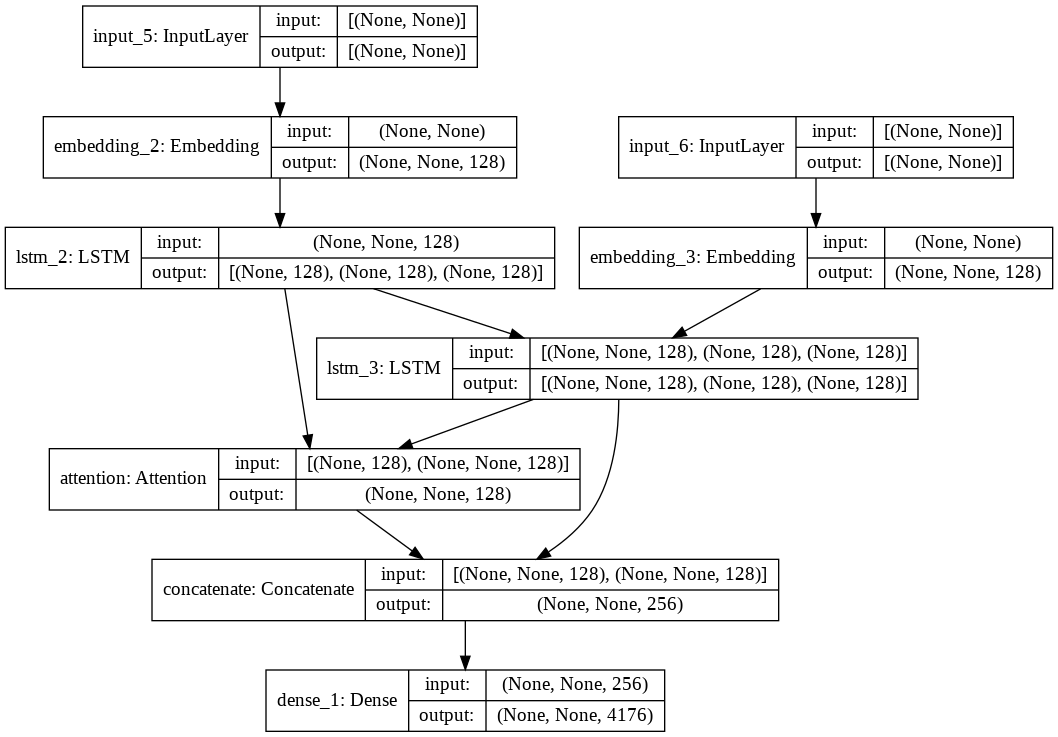

In [ ]:
#Plotting the attention model so I can see it better
tf.keras.utils.plot_model(
    model_attention, show_shapes=True,
    show_layer_names=True
)

In [ ]:
#This runs the training of the attention model with the exact same training data
#May take a while so user beware

#I ran into a problem here where I couldn't train the model. The concatenate layer kept on giving me errors due to mismatching shapes between the output of the attention layer and output
model_attention.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
model_attention.save('seq2seq_source_target_attention.h5')

In [ ]:
#Just a repat for the inference models from before, this time for the model with attention
#This code is the same as my last one but If i got the attention working i would have to make some changes to it 

# define the encoder model again, but it't the exact same
encoder_model_attention = Model(encoder_inputs, encoder_states)


# Redefine the decoder model with decoder will be getting below inputs from encoder while in prediction
decoder_state_input_h = Input(shape=(dim,))
decoder_state_input_c = Input(shape=(dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decode_embeds = frEmbedd(decoder_inputs)

decoder_outputs, state_h, state_c = decoder_lstm(decode_embeds, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]

decoder_outputs = decoder_dense(decoder_outputs)

#The final decoder model
decoder_model_attention_attention = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)



In [ ]:
#another fucntion for making the predictions but this time uses the new model

def decode_sequence_attention(input_seq):
    # Encode the input  state vectors to get state vectors
    states_value = encoder_model_attention.predict(input_seq)
    
    #starting a 1,1 sequence and adding the start character
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = target_token_index['<bof>']

    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model_attention.predict([target_seq] + states_value)
        # Sample a token and add word to decoded sequence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = reverse_target_word_index[sampled_token_index]
        decoded_sentence += ' '+ sampled_word

        # stops when either hit max word or find <eos>
        if (sampled_word == '<eos>' or
           len(decoded_sentence.split()) > max_decoder_seq_length):
            stop_condition = True
        
        # Update the target sequence 
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    #return the decoded_sentence
    return decoded_sentence

In [ ]:
#Declaring list for my results
y_hat_attention = []


#Will calculatge the overall BLEU score for the corpus using the relevant BLEU function from nltk
#Have a lot of testing samples so does take some time

for sent in range (len(encoder_input_test_data)):
  input_sequence = encoder_input_test_data[sent:sent + 1]
  decoded_sentence = decode_sequence_attention(input_sequence)

  #This appends the sentence to the predictions as a list minus the <eos> token as the BLEU function doesnt like it
  y_hat_attention.append(decoded_sentence.split()[:-1])

In [ ]:
 #Printing BLEU for attention model
 BLEU_attention = round(nltk.translate.bleu_score.corpus_bleu(y_true,y_hat_attention),2)
 print("After evaluation on unseen data, we can see our BLEU is ",BLEU_attention)

# Final Analysis
While my original model wasn't the best, I do think it had some promise. It did get a BLEU on average of around 0.3 when the training accuracy was so still so low after 100 epochs. I do think if I left it to train for a long time it would be obtaining good results.
 

While I was not able to get attention working you can see my work and thinking above. While I cannot say for definite as I did not get the results, I do think the attention model would have gotten a better BLEU score than my first model just due to the extra information it adds to the model.
